In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
df.head()


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [5]:
df.drop_duplicates(inplace=True)

# Convert timestamps
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Standardize country codes
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

# Feature engineering
df['duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['duration']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

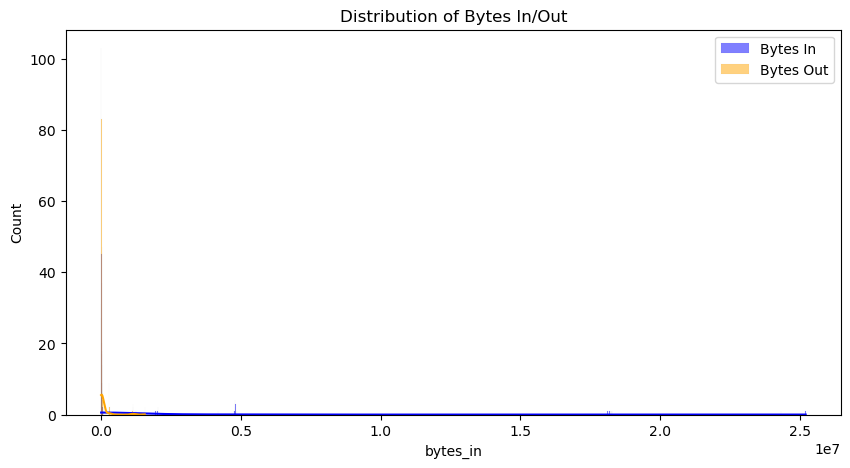

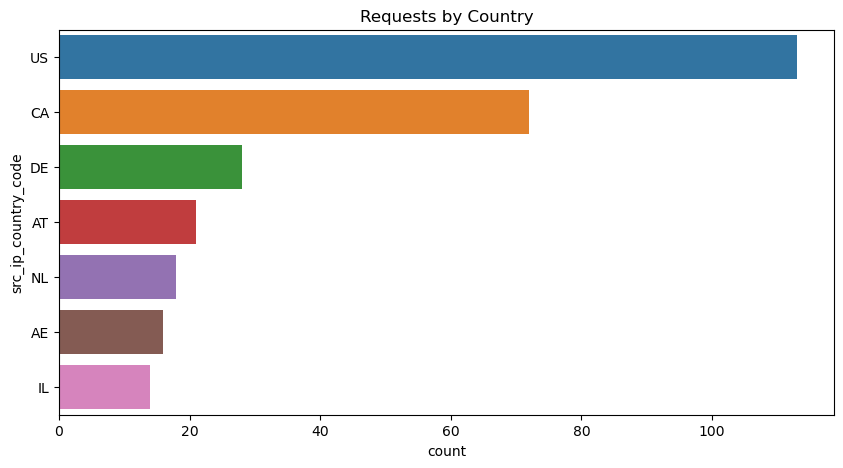

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df['bytes_in'], color='blue', label='Bytes In', kde=True)
sns.histplot(df['bytes_out'], color='orange', label='Bytes Out', kde=True)
plt.title('Distribution of Bytes In/Out')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title('Requests by Country')
plt.show()


In [16]:
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

features = ['bytes_in', 'bytes_out', 'duration', 'avg_packet_size']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

encoder = OneHotEncoder(sparse=False)
X_encoded = encoder.fit_transform(df[['src_ip_country_code']])

# Combine all features
X = np.concatenate([X_scaled, X_encoded], axis=1)
y = df['is_suspicious']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


RF Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # THIS is the fix
)


In [26]:
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)
print(df['is_suspicious'].value_counts())


is_suspicious
1    282
Name: count, dtype: int64


In [28]:
# Artificially convert 20% of class 1 to class 0
df_balanced = df.copy()
num_to_convert = int(len(df_balanced) * 0.2)
df_balanced.loc[df_balanced.sample(n=num_to_convert, random_state=42).index, 'is_suspicious'] = 0

# Now check the balance
print(df_balanced['is_suspicious'].value_counts())


is_suspicious
1    226
0     56
Name: count, dtype: int64


In [30]:
X = np.concatenate([X_scaled, X_encoded], axis=1)
y = df_balanced['is_suspicious']

# Stratified split again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("GB Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


GB Accuracy: 0.6588235294117647
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.77      0.82      0.79        68

    accuracy                           0.66        85
   macro avg       0.38      0.41      0.40        85
weighted avg       0.61      0.66      0.64        85



Silhouette Score (KMeans): 0.9558167767551898


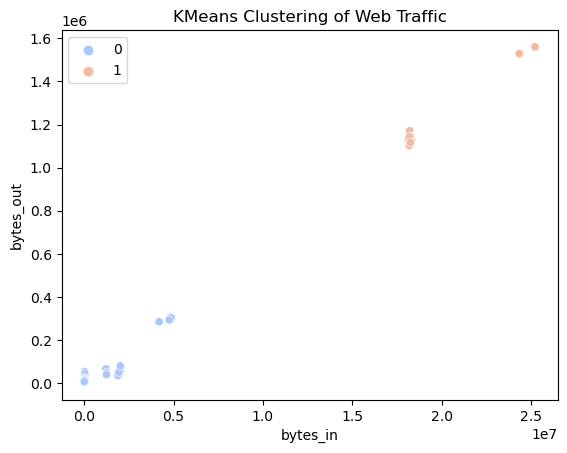

In [32]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df['cluster'] = cluster_labels
sil_score = silhouette_score(X_scaled, cluster_labels)
print("Silhouette Score (KMeans):", sil_score)

sns.scatterplot(x=df['bytes_in'], y=df['bytes_out'], hue=cluster_labels, palette='coolwarm')
plt.title("KMeans Clustering of Web Traffic")
plt.show()


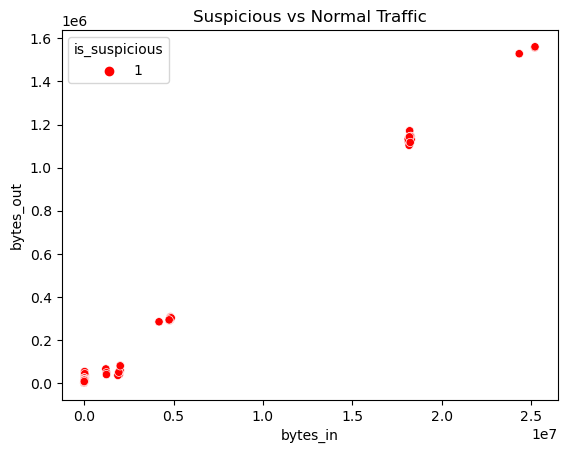

In [34]:
sns.scatterplot(x='bytes_in', y='bytes_out', hue='is_suspicious', data=df, palette={0: 'green', 1: 'red'})
plt.title("Suspicious vs Normal Traffic")
plt.show()
